In [1]:
import sqlite3
from collections import Counter
import re
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
from mordecai import Geoparser
import spacy


# Helper Functions

In [2]:
def run_query(database_path, query):
    # Connect to the SQLite database
    # If the database does not exist, it will be created
    connection = sqlite3.connect(database_path)
    
    try:
        # Create a cursor object using the connection
        cursor = connection.cursor()
        
        # Execute the SQL query
        cursor.execute(query)
        
        # Fetch all results from the executed query
        results = cursor.fetchall()
        
        # Turning list of tuples to list of strings for further processing
        return [str(t[0]) for t in results]

            
    except sqlite3.Error as e:
        print(f"An error occurred: {e}")
        
    finally:
        
        # Close the connection to the database
        if connection:
            connection.close()


In [8]:
def analyze_term_frequency(names):
    # Join all names into a single string
    all_names = ' '.join(names)
    
    # Tokenize the string into words using regex to handle different delimiters
    words = re.findall(r'\b\w+\b', all_names.lower())
    
    # Count the frequency of each word using Counter
    term_frequency = Counter(words)
    
    return term_frequency

In [30]:

def plot_top_terms(term_frequency, top_n=10):
    # Get the most common terms and their frequencies
    common_terms = term_frequency.most_common(top_n)
    
    # Separate terms and frequencies for plotting
    terms, frequencies = zip(*common_terms)
    
    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(terms, frequencies, color='skyblue')
    
    # Add title and labels
    plt.title('Top Occurring Terms')
    plt.xlabel('Terms')
    plt.ylabel('Frequency')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Show plot
    plt.tight_layout()
    plt.show()


In [35]:
def extract_geographical_indicators_RB(company_name, indicators):
    found_indicators = []
    for indicator in indicators:
        if indicator.lower() in company_name.lower():
            found_indicators.append(indicator)
    return found_indicators

In [39]:
def extract_geographical_indicators_TB(company_name):
    # Tokenize input text
    inputs = tokenizer(company_name, return_tensors="pt")

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs).logits

    # Get predicted token classes
    predictions = torch.argmax(outputs, dim=2)

    # Extract geographical indicators based on predicted classes
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    predicted_labels = [labels[prediction] for prediction in predictions[0]]

    # Collect location entities
    locations = []
    for token, label in zip(tokens, predicted_labels):
        if label.startswith("B-LOC"):
            locations.append(token)

    return locations


# Company Type and Status
Identify the type of company based on suffixes like "GmbH," "e.K.," or "Union," which indicate the legal structure (e.g., GmbH for a limited liability company in Germany)


In [26]:
# Example usage
database_path = 'openregister.db'  # Path to your SQLite database file
query = 'SELECT name FROM company LIMIT 100;'  # Replace 'your_table' with your actual table name

list_all_names = run_query(database_path, query)

In [29]:
# Analyze term frequency in names
term_frequency = analyze_term_frequency(list_all_names)

# Sort the term frequency dictionary by frequency in descending order
sorted_term_frequency = sorted(term_frequency.items(), key=lambda item: item[1], reverse=True)

# Print sorted term frequency results
for term, freq in sorted_term_frequency:
    print(f"'{term}': {freq}")

'gmbh': 66
'mbh': 17
'ug': 9
'haftungsbeschränkt': 9
'verwaltung': 8
'co': 8
'kg': 7
'verwaltungs': 6
'beteiligungsgesellschaft': 4
'und': 4
'management': 4
'ms': 4
'verwaltungsgesellschaft': 4
'deutschland': 3
'hamburg': 3
'trading': 3
'services': 3
'bremen': 2
'ag': 2
'zweite': 2
'für': 2
'rembert': 2
'handelsgesellschaft': 2
'treuhand': 2
'holding': 2
'gesellschaft': 2
'europe': 2
'systems': 2
'germany': 2
'system': 2
'aktiengesellschaft': 2
'vermietungsgesellschaft': 2
'olly': 1
'bluechilled': 1
'mittelständische': 1
'albert': 1
'barufe': 1
'itergo': 1
'informationstechnologie': 1
'rheinbahn': 1
'ifö': 1
'immobilienfonds': 1
'österreich': 1
'aws': 1
'personalmarketing': 1
'rechtsanwälte': 1
'müller': 1
'putzier': 1
'partner': 1
'eingetragene': 1
'partnerschaft': 1
'mit': 1
'beschränkter': 1
'berufshaftung': 1
'pox': 1
'media': 1
'hb': 1
'digital': 1
'neunte': 1
'grundstücksverwaltung': 1
'ahg': 1
'beteiligungs': 1
'wpd': 1
'windparks': 1
'westfalen': 1
'iv': 1
'palletways': 1
's': 

### Results 
The Results indicate to me that at least some entities could be extracted by using hardcoded filters. Examples could be the Company Purpose (Gastgewerbe, Hotels, ...) or the company type (GmbH, KG, ...).
An example can be found in the plot below.  

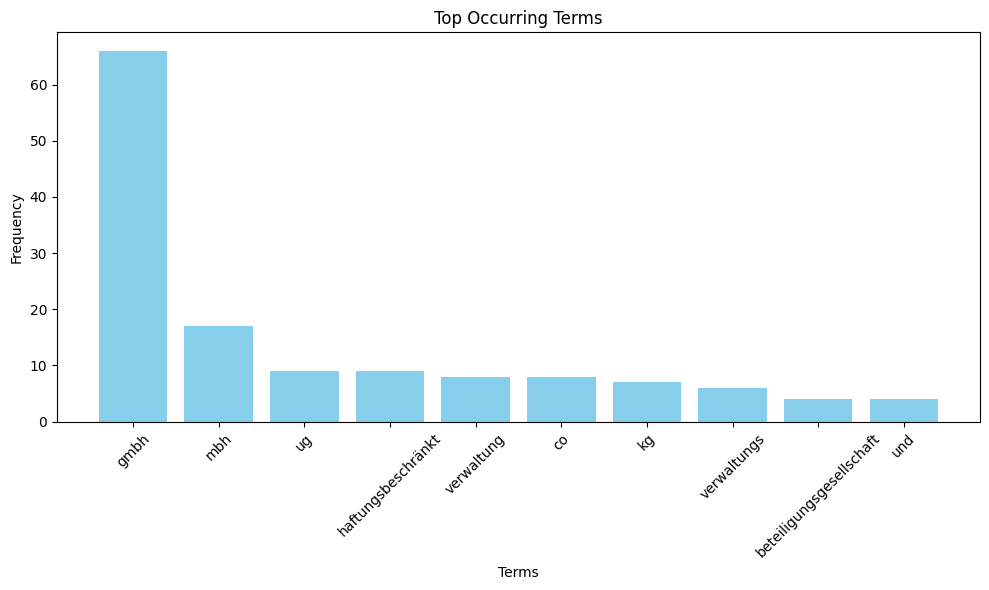

In [31]:
plot_top_terms(term_frequency, top_n=10)

# Geographical Information

## Hard-Coded Rules/Vocabulary for Geo ER
As a starting point/benchmark:

In [32]:
geographical_indicators = [
    "Algeria", "Germany", "France", "USA", "China", "India", "Brazil",
    # Add more countries, cities, or regions as needed
]

In [33]:
database_path = 'openregister.db'  # Path to your SQLite database file
query = 'SELECT name FROM company LIMIT 100;'  # Replace 'your_table' with your actual table name

company_names = run_query(database_path, query)

In [36]:
for name in company_names:
    indicators = extract_geographical_indicators_RB(name, geographical_indicators)
    if indicators:
        print(f"Company Name: '{name}' -> Geographical Indicators: {indicators}")

Company Name: 'NXP Semiconductors Germany GmbH' -> Geographical Indicators: ['Germany']
Company Name: 'Eurofins GSC Germany GmbH' -> Geographical Indicators: ['Germany']


## ML-Based Approach for Geo ER


## Geobert (Fined Tuned BERT)

In [41]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("k4tel/geo-bert-multilingual")
model = AutoModelForTokenClassification.from_pretrained("k4tel/geo-bert-multilingual")

# Define labels (assuming these are provided with the model)
labels = ["O", "B-LOC", "I-LOC"]  # Example labels for Outside, Beginning of Location, Inside Location

# Example usage
company_names = run_query(database_path, query)

for name in company_names:
    indicators = extract_geographical_indicators_TB(name)
    print(f"Company Name: '{name}' -> Geographical Indicators: {indicators}")

/Users/dominikpichler/Documents/Git/OpenSource/Balmung/ER-NLP/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at k4tel/geo-bert-multilingual and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Company Name: 'olly UG (haftungsbeschränkt)' -> Geographical Indicators: ['[CLS]', 'ol', '##ly', 'U', '##G', '(', 'haft', '##ung', '##s', '##bes', '##ch', '##r', '##änkt', ')', '[SEP]']
Company Name: 'BLUECHILLED Verwaltungs GmbH' -> Geographical Indicators: ['[CLS]', 'BL', '##UE', '##CH', '##IL', '##LE', '##D', 'Verwaltung', '##s', 'GmbH', '[SEP]']
Company Name: 'Mittelständische Beteiligungsgesellschaft Bremen mbH' -> Geographical Indicators: ['[CLS]', 'Mittel', '##stä', '##ndi', '##sche', 'Beteiligung', '##sgesellschaft', 'Bremen', 'm', '##b', '##H', '[SEP]']
Company Name: 'Albert Barufe GmbH' -> Geographical Indicators: ['[CLS]', 'Albert', 'Baru', '##fe', 'GmbH', '[SEP]']
Company Name: 'ITERGO Informationstechnologie GmbH' -> Geographical Indicators: ['[CLS]', 'IT', '##ER', '##GO', 'Information', '##ste', '##chn', '##ologie', 'GmbH', '[SEP]']
Company Name: 'Rheinbahn AG' -> Geographical Indicators: ['[CLS]', 'Rhein', '##bahn', 'AG', '[SEP]']
Company Name: 'Verwaltung IFÖ Zweite Imm

Out of the box, it seems that is not working that well... 

## Mordecai

[Github Repo](https://github.com/openeventdata/mordecai)

It uses spaCy's named entity recognition to extract placenames from the text.

It uses the geonames gazetteer in an Elasticsearch index (with some custom logic) to find the potential coordinates of extracted place names.

It uses neural networks implemented in Keras and trained on new annotated English-language data labeled with Prodigy to infer the correct country and correct gazetteer entries for each placename.

In [43]:
!python -m spacy download en_core_web_lg 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.7/782.7 MB 2.2 MB/s eta 0:00:0000:0100:04
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_web_lg: filename=en_core_web_lg-2.3.1-py3-none-any.whl size=782936103 sha256=201b16d8734a2fe1db07d22dd06b76f422328af83b062a617d8099c611d66fe6
  Stored in directory: /Users/dominikpichler/Library/Caches/pip/wheels/08/6c/5c/3eb7da3af2dcb26aaf97a09112e235d78c3968c3248eebd688
Successfully built en_core_web_lg

[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
%%sh
docker pull elasticsearch:5.5.2
wget https://andrewhalterman.com/files/geonames_index.tar.gz --output-file=wget_log.txt
tar -xzf geonames_index.tar.gz
docker run -d -p 127.0.0.1:9200:9200 -v $(pwd)/geonames_index/:/usr/share/elasticsearch/data elasticsearch:5.5.2

In [6]:
database_path = 'openregister.db'  # Path to your SQLite database file
query = 'SELECT name FROM company LIMIT 100;' 
company_names = run_query(database_path, query)

geo = Geoparser()
for company_name in company_names:
    geo.geoparse(company_name)

Models path: /Users/dominikpichler/Documents/Git/OpenSource/Balmung/ER-NLP/.venv/lib/python3.11/site-packages/mordecai/models/


AttributeError: module 'collections' has no attribute 'Mapping'

<span style="color: red;"><br>Unfortunately the setup failed.<br> Partly due to my M1 Architecture. I'll retry later, but due to time contraints, I'll try different tools first</span>



I assume that maybe this task could also be solved best by applying Rule Based Extraction, as it is pretty clear what can be expected here.

Rules might be extractable from sources like the following: 
[EU portal for EU data](https://data.europa.eu/en)


In [ ]:
# Owner- or founders names: 

In [8]:
from pprint import pprint
from german_nouns.lookup import Nouns

# Initialize the Nouns object
nouns = Nouns()

def preprocess_text(text):
    """Tokenize and normalize the input text."""
    # Remove punctuation and split text into words
    words = re.findall(r'\b\w+\b', text.lower())
    return words

def filter_non_standard_words(text, nouns):
    """Filter out German nouns from the text."""
    words = preprocess_text(text)
    non_standard_words = [word for word in words if word not in nouns]
    return non_standard_words

# Example usage
text = """
Herr Müller ging mit Frau Schmidt in den Park. Dort trafen sie auf einen alten Freund, Herr Becker.
"""

# Filter out standard German nouns
non_standard_words = filter_non_standard_words(text, nouns)
print("Potential Names or Non-Standard Words:", non_standard_words)

Potential Names or Non-Standard Words: ['herr', 'müller', 'ging', 'mit', 'frau', 'schmidt', 'in', 'den', 'park', 'dort', 'trafen', 'sie', 'auf', 'einen', 'alten', 'freund', 'herr', 'becker']


In [6]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 6.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for de_core_news_sm: filename=de_core_news_sm-2.3.0-py3-none-any.whl size=14907560 sha256=4953d739953dcf8fd9356af56428a24aded37e3f38d113d3815a7b13c7d67eb6
  Stored in directory: /Users/dominikpichler/Library/Caches/pip/wheels/32/6d/3d/c14f49fda18b39ba779ababe9b457bc7f35d58b5f21c1631f0
Successfully built de_core_news_sm

[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [ ]:
import spacy

# Load English and German models
nlp_en = spacy.load("en_core_web_sm")
nlp_de = spacy.load("de_core_news_sm")

# Example English and German texts
english_text = "Elon R. Musk, Jeff Bezos, and Tim Apple were mentioned in the meeting while staying in munich."


raw_german = "Dr. Gottfried Neuhaus Treuhand GmbH"
german_text = "Angela Merkel und Olaf Scholz wurden im Treffen erwähnt."

def extract_person_names(text, nlp_model):
    # Process the text using the specified language model
    doc = nlp_model(text)
    # Extract person names
    z = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
    
    return [ent.text for ent in doc.ents if ent.label_ == "PERSON"]

# Extract names from English text
english_names = extract_person_names(english_text, nlp_en)
print("English names:", english_names)

# Extract names from German text
german_names = extract_person_names(raw_german, nlp_de)
print("German names:", german_names)

Alternative, names could also be transled to english using pythons [GoogleTrans](https://pypi.org/project/googletrans/) Package